In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

In [27]:
data=pd.read_csv('../input/the-boston-houseprice-data/boston.csv')
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [29]:
data.describe().style.background_gradient(cmap='jet')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# Data Preprocessing

**Let's rename the columns names of the target variabels**

In [30]:
data.rename(columns={'MEDV':'Price'},inplace=True)

In [31]:
#Check the null values
data.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
Price      0
dtype: int64

<AxesSubplot:xlabel='Price', ylabel='Count'>

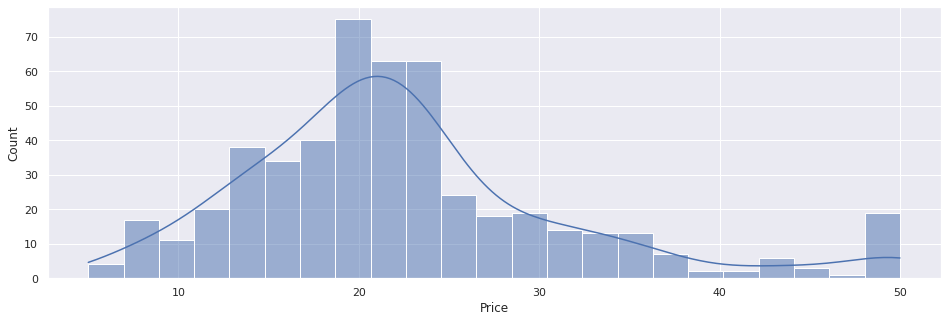

In [32]:
sns.set(rc={'figure.figsize':(16,5)})
sns.histplot(data['Price'],kde=True,stat='count',
    bins='auto',palette='red')

In [33]:
X=data.drop(['Price'],axis=1).values
y=data[['Price']].values

In [34]:
X_test=torch.from_numpy(X).float()
y_test=torch.from_numpy(y).float()

In [35]:
print(X_test.shape)
print(y_test.shape)

torch.Size([506, 13])
torch.Size([506, 1])


In [36]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.10
TEST_SIZE = 0.20
SHUFFLE = True
def split(X, y, val_size, test_size, shuffle):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = shuffle)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size, shuffle = shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test


In [37]:
X_train, X_val, X_test, y_train, y_val, y_test = split(X, y, VAL_SIZE, TEST_SIZE, SHUFFLE)

In [38]:
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_test: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (363, 13), y_train: (363, 1)
X_val: (41, 13), y_test: (41, 1)
X_test: (102, 13), y_test: (102, 1)


In [39]:
x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [40]:
# Apply scaler on training and test data
X_train = x_scaler.transform(X_train)
y_train = y_scaler.transform(y_train).ravel().reshape(-1, 1)
X_val = x_scaler.transform(X_val)
y_val = y_scaler.transform(y_val).ravel().reshape(-1, 1)
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test).ravel().reshape(-1, 1)

In [41]:
INPUT_DIM = X_train.shape[1] # X is 1-dimensional
OUTPUT_DIM = y_train.shape[1] # y is 1-dimensional

In [42]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)
        
    def forward(self, x_in):
        y_pred = self.fc1(x_in)
        return y_pred

In [43]:
# Initialize model
from torchsummary import summary
model = LinearRegression(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)
print (model.named_parameters)
summary(model, input_size=(INPUT_DIM,)) 

<bound method Module.named_parameters of LinearRegression(
  (fc1): Linear(in_features=13, out_features=1, bias=True)
)>
Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            14
Total params: 14
Trainable params: 14
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            14
Total params: 14
Trainable params: 14
Non-trainable params: 0

In [44]:
from torch.optim import Adam
loss_fn = nn.MSELoss()
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1) 
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [45]:
# Training
NUM_EPOCHS = 100
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    
    if epoch%20==0: 
        print (f"Epoch: {epoch} | loss: {loss:.2f}")

Epoch: 0 | loss: 1.06
Epoch: 20 | loss: 0.27
Epoch: 40 | loss: 0.25
Epoch: 60 | loss: 0.24
Epoch: 80 | loss: 0.24


In [46]:
# Predictions
pred_train = model(X_train)
pred_test = model(X_test)
# Performance
train_error = loss_fn(pred_train, y_train)
test_error = loss_fn(pred_test, y_test)
print(f'train_error: {train_error:.2f}')
print(f'test_error: {test_error:.2f}')

train_error: 0.24
test_error: 0.31


In [47]:
y_test = y_test.detach().numpy()
pred_test = pred_test.detach().numpy()

In [48]:
r2 = r2_score(y_test, pred_test)
print(f"The r2_score is {r2*100:.2f}")

The r2_score is 75.19
